In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from importlib import import_module
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1000)
ONE_HOT_LABEL = True

Using TensorFlow backend.


In [2]:
def count_data(data):
    if ONE_HOT_LABEL:
        data = data.dot(np.arange(0,5)).astype('uint8')
    unique, counts = np.unique(data, return_counts=True)
    print(dict(zip(unique, counts)))

In [3]:
# # (2) Get Data
# import tflearn.datasets.oxflower17 as oxflower17
# x, y = oxflower17.load_data(one_hot=True)

DATADIR = '/Users/yanxiang.zyx/KIPRO/associative_deep_clustering/semisup/data/npy/'

dataset_tools = import_module('tools.material')

train_images, test_images, train_labels,  test_labels = dataset_tools.get_data(one_hot=ONE_HOT_LABEL, test_size=0.1)

class_names = ['Cardboard', 'Pamphlet', 'Empty', 'Plastic Foil', 'Shredded Paper']

NUM_LABELS = dataset_tools.NUM_LABELS
IMAGE_SHAPE = dataset_tools.IMAGE_SHAPE

print(train_images.shape)

count_data(train_labels)
count_data(test_labels)

(450, 227, 227, 3)
{0: 85, 1: 93, 2: 97, 3: 88, 4: 87}
{0: 15, 1: 7, 2: 3, 3: 12, 4: 13}


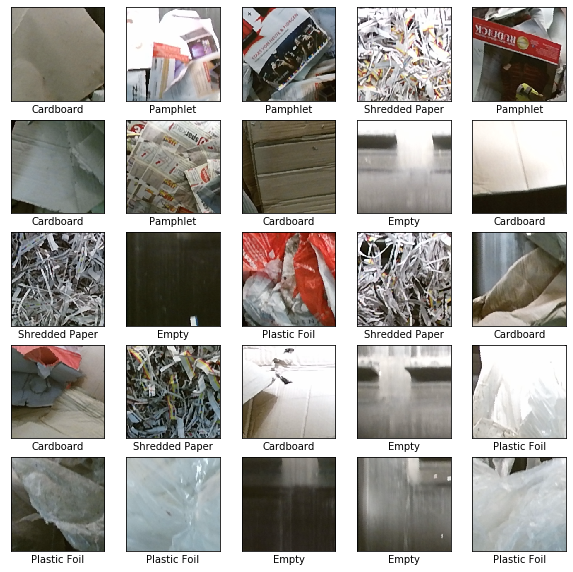

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(train_labels[i])])
plt.show()

In [5]:
# (3) Create a sequential model
model = Sequential()

# model.add(Dropout(0.5, input_shape=IMAGE_SHAPE))
model.add(BatchNormalization(input_shape=IMAGE_SHAPE, \
        axis=-1, momentum=0.9, epsilon=0.001, center=True, scale=True, beta_initializer='zeros',\
        gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None,\
        gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))

# 1st Convolutional Layer
model.add(Conv2D(filters=96, \
     kernel_size=(11,11), strides=(4,4), padding='valid',\
     trainable=False, \
     activation = 'relu', \
     kernel_initializer='glorot_uniform'))
# Pooling 
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2),\
        trainable=False, \
        padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', \
         trainable=False, \
         activation = 'relu', \
         kernel_initializer='glorot_uniform'))
# Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), \
        trainable=False, \
        padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', \
         trainable=False, \
         activation = 'relu', \
         kernel_initializer='glorot_uniform'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', \
         activation = 'relu', \
         kernel_initializer='glorot_uniform'))
model.add(BatchNormalization(momentum=0.9))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', \
         activation = 'relu', \
         kernel_initializer='glorot_uniform'))
model.add(BatchNormalization(momentum=0.9))
# Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# Passing it to a dense layer
model.add(Flatten())

# 1st Dense Layer
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 2nd Dense Layer
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(5))
model.add(Activation('softmax'))

model.summary()

W1021 10:44:26.212346 4496538944 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 227, 227, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 384)      

In [6]:
def get_lr_metric(a):
    def lr(y_true, y_pred):
        return a.lr
    return lr

In [7]:
# (4) Compile 
loss_func = 'categorical_crossentropy' if ONE_HOT_LABEL else 'sparse_categorical_crossentropy'
adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0001, amsgrad=False)
# model.compile(loss=loss_func, optimizer=adam, metrics=['accuracy'])
# lr_metric = get_lr_metric(adam)

model.compile(loss=loss_func, optimizer=adam, metrics=['accuracy'])
each_epoch = 10
total_epochs = 0

In [8]:
# (5) Train
print(total_epochs)
total_epochs += each_epoch
model.fit(train_images, train_labels, epochs=each_epoch, verbose=1, validation_split=0.2, shuffle=True)

0


W1021 10:44:46.161370 4496538944 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 360 samples, validate on 90 samples
Epoch 1/10
360/360 [==============================] - 15s 42ms/step - loss: 3.0878 - accuracy: 0.4056 - val_loss: 1.6247 - val_accuracy: 0.4000
Epoch 2/10
360/360 [==============================] - 15s 42ms/step - loss: 2.2216 - accuracy: 0.5250 - val_loss: 1.6981 - val_accuracy: 0.4000
Epoch 3/10
360/360 [==============================] - 15s 41ms/step - loss: 1.6638 - accuracy: 0.5861 - val_loss: 1.1770 - val_accuracy: 0.5000
Epoch 4/10
360/360 [==============================] - 15s 42ms/step - loss: 1.5589 - accuracy: 0.5583 - val_loss: 1.2320 - val_accuracy: 0.5222
Epoch 5/10
360/360 [==============================] - 16s 43ms/step - loss: 1.5973 - accuracy: 0.6000 - val_loss: 1.0040 - val_accuracy: 0.6333
Epoch 6/10
360/360 [==============================] - 17s 46ms/step - loss: 1.2107 - accuracy: 0.6528 - val_loss: 0.9771 - val_accuracy: 0.6556
Epoch 7/10
360/360 [==============================] - 16s 44ms/step - loss: 1.0513 - accura

In [61]:
# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=1)
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=1)

print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)

50/50 [==============================] - 1s 10ms/step

Test loss: 1.0711527681350708

Test accuracy: 0.6000000238418579


In [72]:
pred_images, pred_labels = train_images, train_labels

predictions = model.predict(pred_images)

pred_len = len(predictions)
count = 0
for i in range(pred_len):
    _label = np.argmax(pred_labels[i]) if ONE_HOT_LABEL else pred_labels[i]
    if _label == np.argmax(predictions[i]):
        count += 1
print(count)
print(count/pred_len)

379
0.8422222222222222


In [73]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]

  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  if ONE_HOT_LABEL:
    true_label = np.argmax(true_label)
    
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  if ONE_HOT_LABEL:
    true_label = np.argmax(true_label)
  plt.grid(False)
  plt.xticks(range(NUM_LABELS))
  plt.yticks([])
  thisplot = plt.bar(range(NUM_LABELS), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

NameError: name 'predict_labels' is not defined

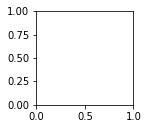

In [74]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], pred_labels, pred_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], pred_labels)
plt.tight_layout()
plt.show()